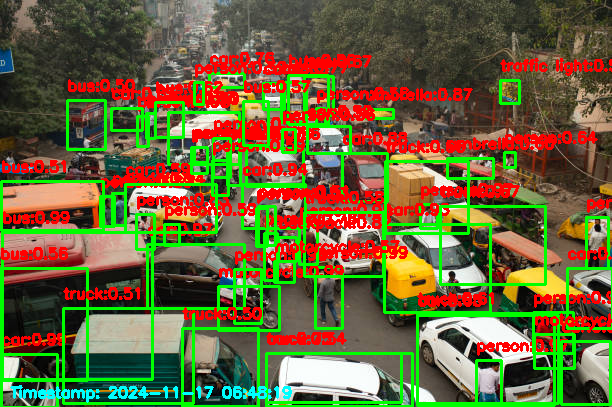

In [4]:
import torch
import torchvision
from torchvision.transforms import functional as F
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from datetime import datetime

# Load pretrained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# COCO dataset class labels
COCO_INSTANCE_CATEGORY_NAMES = [
    '_background_', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
    'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli',
    'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
    'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
    'teddy bear', 'hair drier', 'toothbrush'
]

def detect_objects(image_path, confidence_threshold=0.5):
    # Read and preprocess the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}. Please check the file path and ensure the image exists.")
        return None

    # Convert BGR to RGB as PyTorch expects RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = image.copy()
    image_tensor = F.to_tensor(image).unsqueeze(0)

    # Perform inference
    with torch.no_grad():
        predictions = model(image_tensor)

    # Extract detection details
    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()

    for i, box in enumerate(boxes):
        if scores[i] > confidence_threshold:
            label_idx = labels[i]

            if 0 <= label_idx < len(COCO_INSTANCE_CATEGORY_NAMES):
                label = COCO_INSTANCE_CATEGORY_NAMES[label_idx]
            else:
                label = "Unknown"

            score = scores[i]
            start_point = (int(box[0]), int(box[1]))
            end_point = (int(box[2]), int(box[3]))

            # Draw bounding box and label
            cv2.rectangle(original_image, start_point, end_point, (0, 255, 0), 2)
            cv2.putText(original_image, f"{label}:{score:.2f}", (start_point[0], start_point[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Add timestamp
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    cv2.putText(original_image, f"Timestamp: {timestamp}", (10, original_image.shape[0] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

    # Convert back to BGR for OpenCV
    original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)
    return original_image

if __name__ == "__main__":
    IMAGE_PATH = "/content/traffic.jpg"
    detected_image = detect_objects(IMAGE_PATH)

    if detected_image is not None:
        # Display the image in Google Colab
        cv2_imshow(detected_image)
